In [4]:
from google.colab import files

# Abrir janela de upload de arquivos
uploaded = files.upload()

#Base baixada do Keggle

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [5]:
import pandas as pd

# Ler o CSV enviado
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Mostrar as primeiras linhas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
import sqlite3

# Criar banco de dados SQLite na memória
conn = sqlite3.connect(":memory:")

# Enviar o DataFrame para o banco como tabela "customers"
df.to_sql("customers", conn, if_exists="replace", index=False)

print("Banco de dados criado com sucesso!")

Banco de dados criado com sucesso!


In [7]:
query = """
SELECT Contract, Churn, COUNT(*) as total
FROM customers
GROUP BY Contract, Churn
ORDER BY total DESC
"""

result = pd.read_sql(query, conn)
result

,Contract,Churn,total
0,Month-to-month,No,2220
1,Month-to-month,Yes,1655
2,Two year,No,1647
3,One year,No,1307
4,One year,Yes,166
5,Two year,Yes,48


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo padrão dos gráficos
sns.set(style="whitegrid")


<ipython-input-9-591c7de4f298>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Churn", palette="Set2")


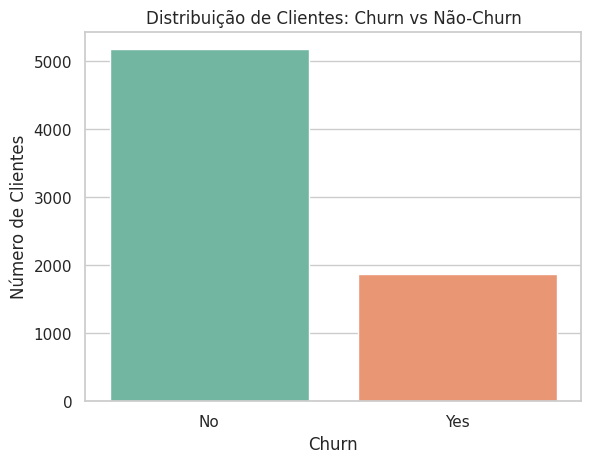

In [9]:
sns.countplot(data=df, x="Churn", palette="Set2")
plt.title("Distribuição de Clientes: Churn vs Não-Churn")
plt.ylabel("Número de Clientes")
plt.show()

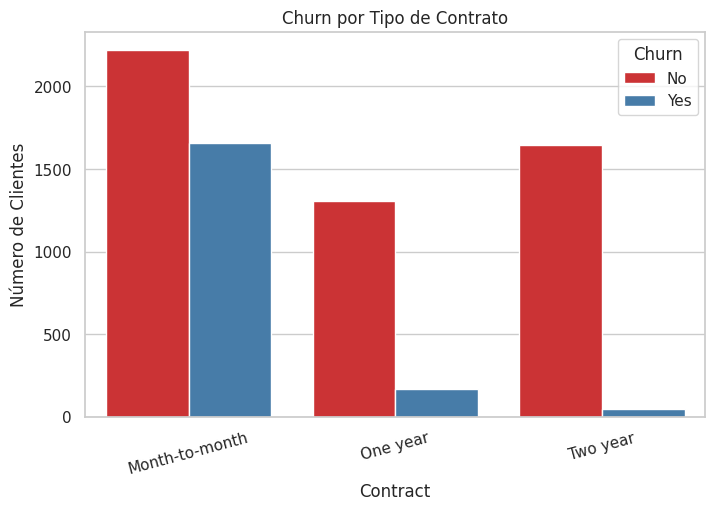

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Contract", hue="Churn", palette="Set1")
plt.title("Churn por Tipo de Contrato")
plt.xticks(rotation=15)
plt.ylabel("Número de Clientes")
plt.show()

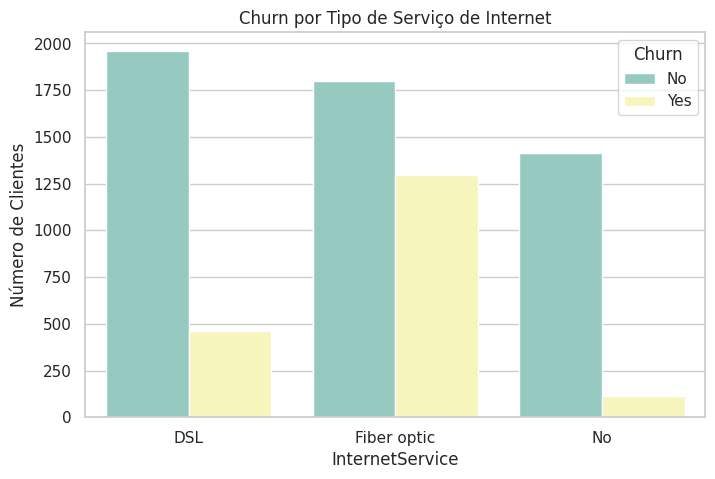

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="InternetService", hue="Churn", palette="Set3")
plt.title("Churn por Tipo de Serviço de Internet")
plt.ylabel("Número de Clientes")
plt.show()

<ipython-input-12-c4fb5c7381a6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y="MonthlyCharges", palette="coolwarm")


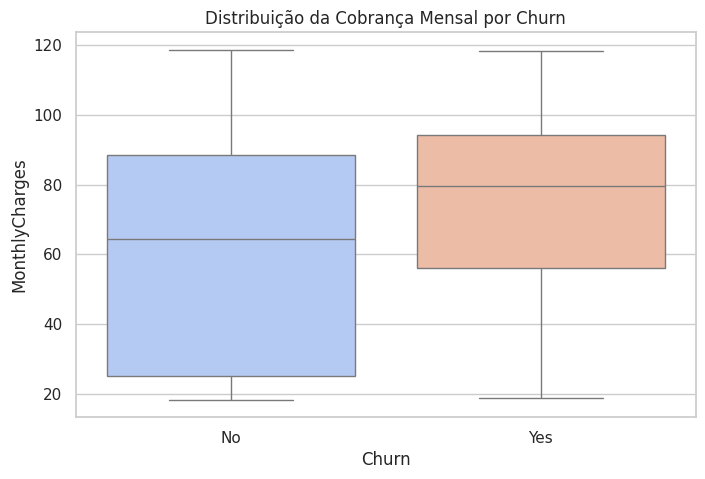

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Churn", y="MonthlyCharges", palette="coolwarm")
plt.title("Distribuição da Cobrança Mensal por Churn")
plt.show()

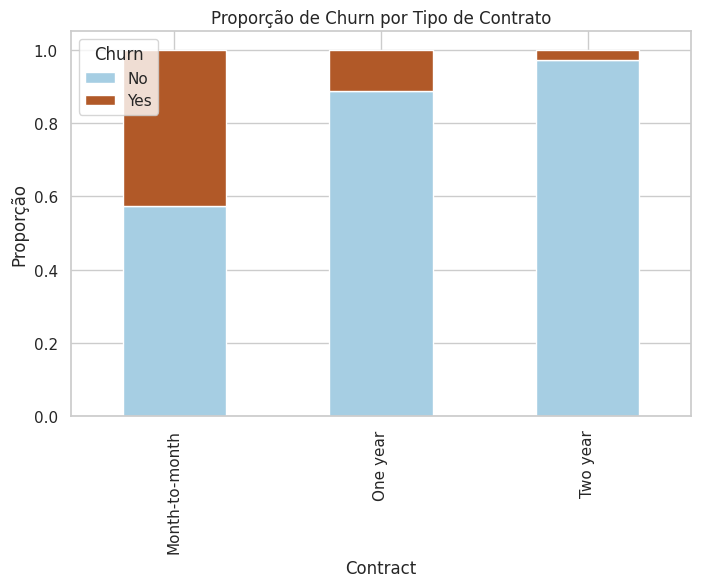

In [13]:
# Tabela de churn por tipo de contrato (em %)
churn_prop = df.groupby(['Contract', 'Churn']).size().unstack().apply(lambda x: x / x.sum(), axis=1)

# Gráfico de barras empilhadas
churn_prop.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Paired')
plt.title("Proporção de Churn por Tipo de Contrato")
plt.ylabel("Proporção")
plt.legend(title="Churn")
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
# Copiar o DataFrame original para não modificar o original
df_model = df.copy()

# Remover a coluna 'customerID'
df_model.drop("customerID", axis=1, inplace=True)

# Converter colunas "TotalCharges" para numérico (tem strings vazias)
df_model["TotalCharges"] = pd.to_numeric(df_model["TotalCharges"], errors="coerce")

# Tratar valores ausentes (opção simples: remover linhas com NaN)
df_model.dropna(inplace=True)

# Codificar variáveis categóricas
for col in df_model.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

In [16]:
# Separar features (X) e target (y)
X = df_model.drop("Churn", axis=1)
y = df_model["Churn"]

# Dividir treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Escalonar os dados para melhorar desempenho do modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Criar e treinar o modelo de regressão logística
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

Matriz de Confusão:


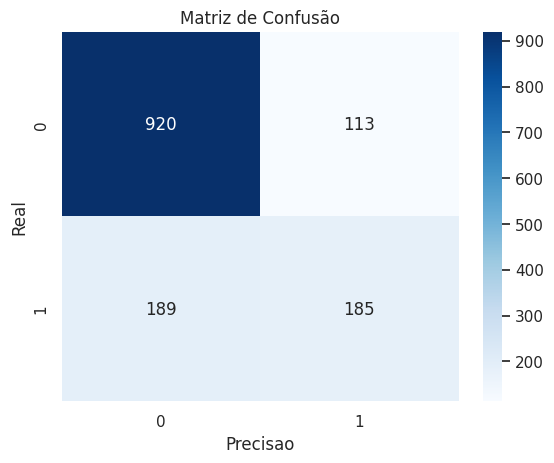

In [19]:
# Fazer previsões
y_pred = model.predict(X_test)

# Mostrar resultados
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Precisao")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

Relatório com class_weight='balanced':
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.81      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407



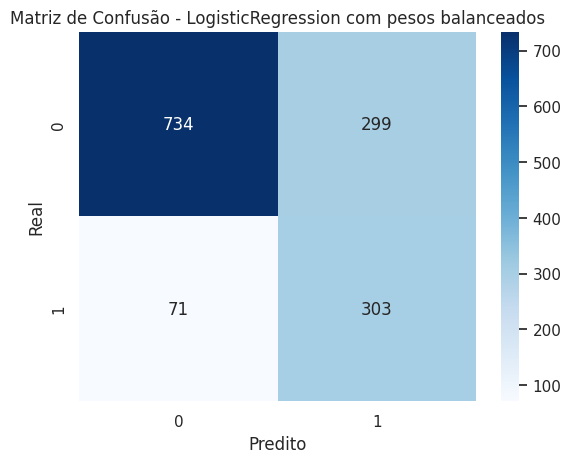

In [20]:
#O número de falsos negativos (189) é maior que os verdadeiros positivos (185).
#O modelo tem boa performance em detectar quem NÃO vai sair.
#Tem muita dificuldade em identificar quem VAI sair (baixa recall).
#Isso mostra que ele ainda não é confiável para ações de retenção baseadas em churn.
#Testar outro modelo mais robusto.RandomForest

# Criar o modelo com pesos balanceados
model_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
model_balanced.fit(X_train, y_train)

# Previsão e avaliação
y_pred_bal = model_balanced.predict(X_test)

# Relatório
print("Relatório com class_weight='balanced':")
print(classification_report(y_test, y_pred_bal))

# Matriz de confusão
sns.heatmap(confusion_matrix(y_test, y_pred_bal), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - LogisticRegression com pesos balanceados")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

Relatório - Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.45      0.53       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.69      1407
weighted avg       0.77      0.78      0.77      1407



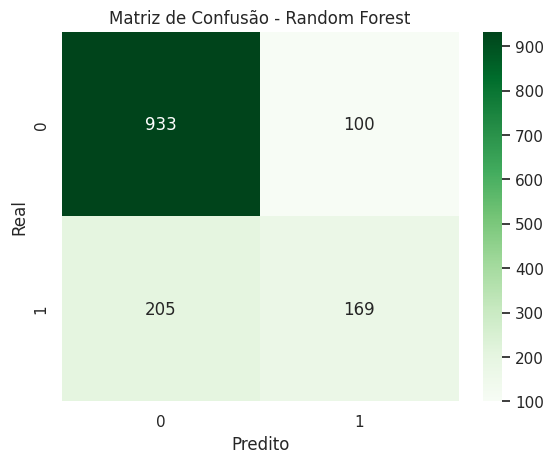

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Criar o modelo Random Forest com pesos balanceados
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Previsão
y_pred_rf = rf_model.predict(X_test)

# Avaliação
print("Relatório - Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusão
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


Threshold = 0.3
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.72      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.74      0.75      1407



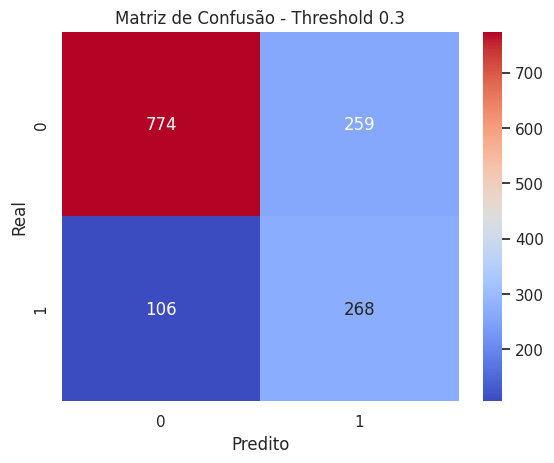


Threshold = 0.4
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.58      0.60      0.59       374

    accuracy                           0.78      1407
   macro avg       0.71      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407



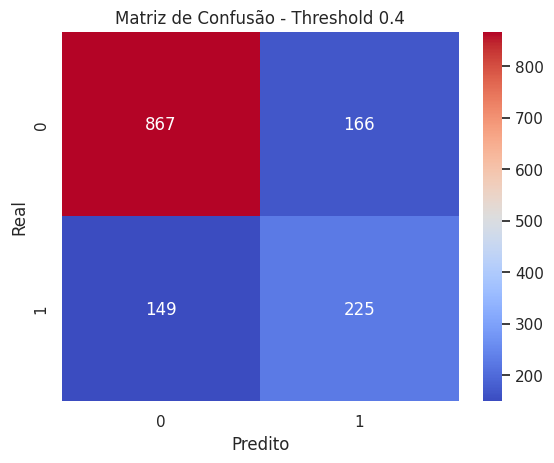


Threshold = 0.5
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.62      0.46      0.53       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.69      1407
weighted avg       0.77      0.78      0.77      1407



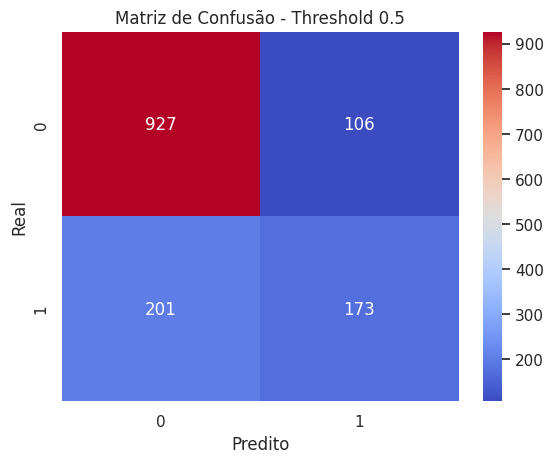


Threshold = 0.6
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1033
           1       0.70      0.36      0.48       374

    accuracy                           0.79      1407
   macro avg       0.75      0.65      0.67      1407
weighted avg       0.78      0.79      0.76      1407



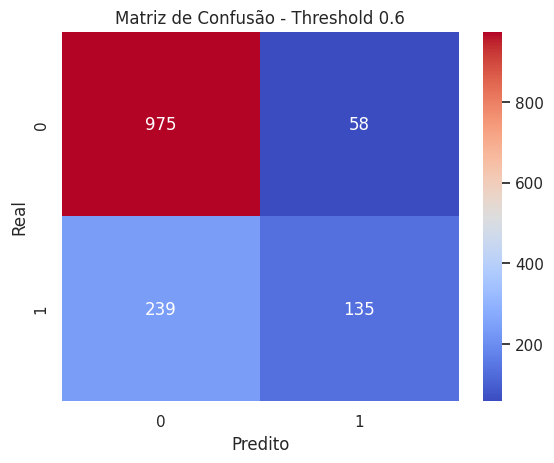

In [22]:
from sklearn.metrics import precision_recall_curve

# Obter as probabilidades da classe 1 (churn)
y_probs = rf_model.predict_proba(X_test)[:, 1]  # para RandomForest
# y_probs = model_balanced.predict_proba(X_test)[:, 1]  # para LogisticRegression

# Definir thresholds para teste
thresholds = [0.3, 0.4, 0.5, 0.6]

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred_thresh))
    sns.heatmap(confusion_matrix(y_test, y_pred_thresh), annot=True, fmt='d', cmap='coolwarm')
    plt.title(f"Matriz de Confusão - Threshold {t}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:04:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Relatório - XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



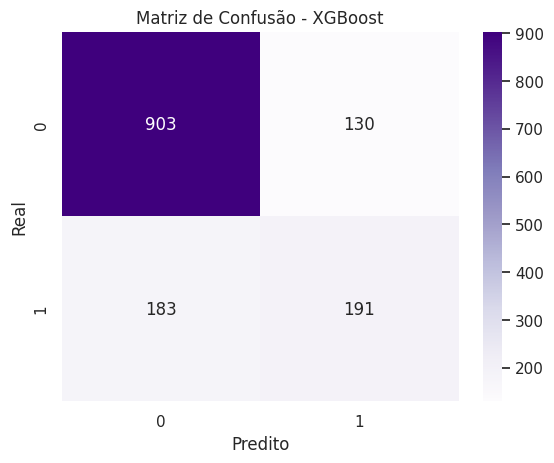

In [23]:
!pip install xgboost

import xgboost as xgb

# Criar o modelo
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Previsão
y_pred_xgb = xgb_model.predict(X_test)

# Avaliação
print("Relatório - XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Matriz de confusão
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Purples')
plt.title("Matriz de Confusão - XGBoost")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

Relatório - Random Forest + SMOTE:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1033
           1       0.57      0.57      0.57       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407



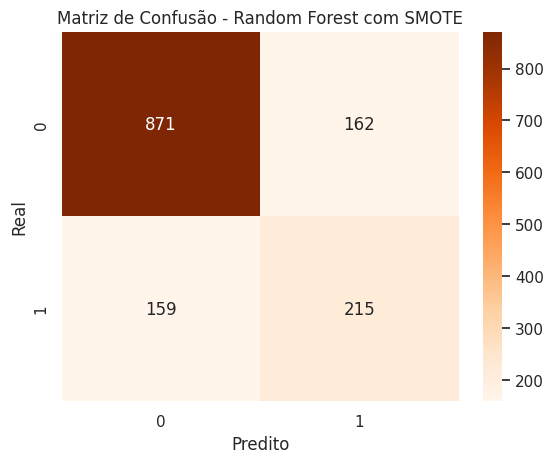

In [24]:
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Treinar novo modelo com dados balanceados
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_sm, y_train_sm)

# Previsão e avaliação
y_pred_sm = rf_smote.predict(X_test)

print("Relatório - Random Forest + SMOTE:")
print(classification_report(y_test, y_pred_sm))

sns.heatmap(confusion_matrix(y_test, y_pred_sm), annot=True, fmt='d', cmap='Oranges')
plt.title("Matriz de Confusão - Random Forest com SMOTE")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

In [25]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_roc(models, X_test, y_test):
    plt.figure(figsize=(8,6))

    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall(models, X_test, y_test):
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:  # Caso use modelo sem predict_proba
            y_scores = model.decision_function(X_test)

        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        avg_precision = average_precision_score(y_test, y_scores)
        plt.plot(recall, precision, label=f"{name} (AP={avg_precision:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision-Recall")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

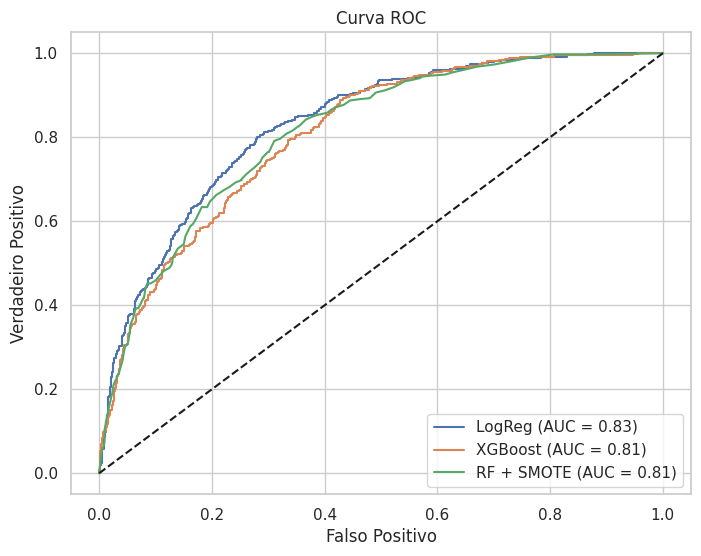

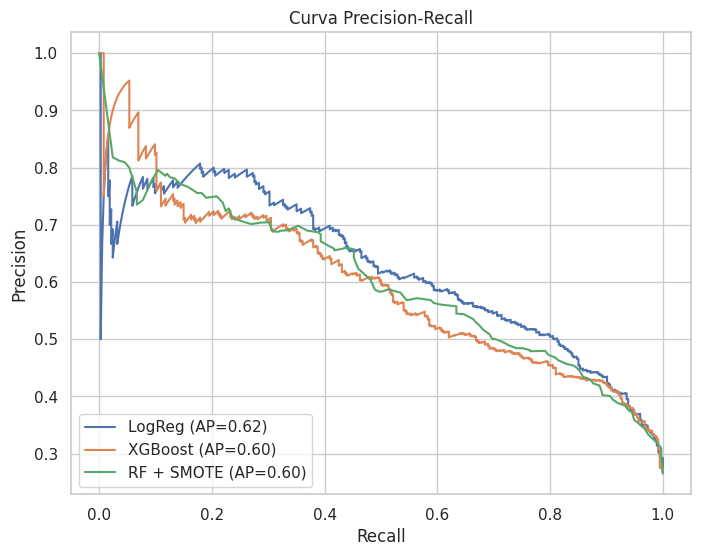

In [27]:
models = {
    'LogReg': model,
    'XGBoost': xgb_model,
    'RF + SMOTE': rf_smote
}

plot_roc(models, X_test, y_test)
plot_precision_recall(models, X_test, y_test)

In [28]:
!pip freeze > requirements.txt